In [69]:
from numpy import *
import numpy as np
from numpy.core.umath import multiply
import matplotlib.pyplot as plt

In [51]:
# 辅助工具
import random


# 加载数据 
def loadDataSet(filename: object) -> object:
    dataMat = []
    labelMat = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split('\t')
        # 坑！ 要用float（）将dataMat、labelMat中的成员转换成浮点类型
        # 否则默认类型是U9，即无符号int 9bit类型，这种类型无法参与之后的multiply（）运算，
        # 会抛出错误：ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32')
        #  dtype('<U32') dtype('<U32')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat


# 随机返回一个不等于i的J
def randomSelectJ(i, m):
    j = i  
    while j == i:
        # 坑！random.uniform()返回变量类型是float类型，无法用于之后的切片操作，需要转换为int
        j = int(random.uniform(0, m))
    return j


# 把aj限制在[L,H]范围内
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


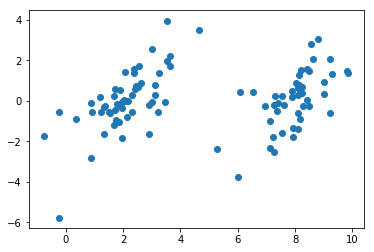

In [81]:
dataMat, labelMat = loadDataSet('MLiA/SVM/testSet.txt')
dataArray = np.array(dataMat)
plt.scatter(dataArray[:, 0], dataArray[:, 1])

dtype('float64')

#简化版SMO实现

In [55]:
def simpleSMO(dataMatIn, classLabels, C, toler, maxIter):
    # 将输入的特征矩阵化，shape为100*2；标签矩阵化后转置，shape为100*1
    dataMat = mat(dataMatIn)
    labelMat = mat(classLabels).transpose()
    # 初始化b，样本数量m，特征数量n
    b = 0
    m, n = shape(dataMat)
    # 初始化参数α为全0向量 m*1 即100*1
    alphas = mat(zeros((m, 1)))
    # 初始化当前遍历次数iter为0 ，当iter == maxIter时，结束循环
    iter = 0
    while iter < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            # f(xi) = w.T * x + b
            fxi = float(multiply(alphas, labelMat).T * (dataMat * dataMat[i, :].T)) + b
            # 误差Ei = f(xi) - yi，用于之后的计算
            Ei = fxi - float(labelMat[i])
            # todo （疑问点）检查KKT条件是否满足
            if ((labelMat[i] * Ei < -toler) and (alphas[i] < C)) or ((labelMat[i] * Ei > toler) and (alphas[i] > 0)):
                # 现在开始处理第二个参数alphaJ，由于是简化版smo，先随机选择j
                j = randomSelectJ(i, m)
                # 计算f(xj),Ej ,计算方法用i
                fxj = float(multiply(alphas, labelMat).T * (dataMat * dataMat[j, :].T)) + b
                Ej = fxj - float(labelMat[j])
                # 为ai，aj 分配新内存，以免被修改
                alphaIOld = alphas[i].copy()
                alphaJOld = alphas[j].copy()
                # 设置alpha的上限H、下限L，用于裁剪，使其满足范围(0,C)
                if labelMat[i] != labelMat[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H:
                    print("L==H")
                    continue
                #  计算η = K11 + K22 - 2*K12; 这里取其相反数
                eta = 2 * dataMat[i, :] * dataMat[j, :].T - dataMat[i, :] * dataMat[i, :].T \
                      - dataMat[j, :] * dataMat[j, :].T
                if eta >= 0:
                    print("eta >= 0")
                    continue
                # 更新aj的值 。具体公式推导见《统计学习方法》7.4.1节 定理7.6
                alphas[j] -= labelMat[j] * (Ei - Ej) / eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                # 判断更改是否过小
                if abs(alphas[j] - alphaJOld) < 0.00001:
                    print("j not moving enough")
                    continue
                # 用aj 更新ai
                alphas[i] += labelMat[j] * labelMat[i] * (alphaJOld - alphas[j])  # update i by the same amount as j
                # todo (疑问点)更新b的值。 ai，aj 若在(0,C)之间，则b1 = b2的，所以b = b1 = b2
                # todo 若ai，aj 等于0或C 则bi,bj之间的数都是满足KKT的，此时用bi bj的中间值作为b值
                # todo 具体公式推导见《统计学习方法》7.4.2节 其3.
                bi = b - Ei - labelMat[i] * dataMat[i, :] * dataMat[i, :].T * (alphas[i] - alphaIOld) - labelMat[j] * \
                     dataMat[j, :] * dataMat[i, :].T * (alphas[j] - alphaJOld)
                bj = b - Ej - labelMat[i] * dataMat[i, :] * dataMat[j, :].T * (alphas[i] - alphaIOld) - labelMat[j] * \
                     dataMat[j, :] * dataMat[j, :].T * (alphas[j] - alphaJOld)
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = bi
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = bj
                else:
                    b = (bi + bj) / 2.0
                # 使更新alpha数+1，用于控制循环
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            if alphaPairsChanged == 0:
                iter += 1
            else:
                iter = 0
            print("iteration number: %d" % iter)
        return b, alphas


In [109]:
b, alphas = simpleSMO(dataMat,labelMat, 0.6, 0.001, 40)

L==H
iter: 0 i:1, pairs changed 1
iteration number: 0
iter: 0 i:2, pairs changed 2
iteration number: 0
iteration number: 0
j not moving enough
j not moving enough
L==H
iteration number: 0
iteration number: 0
iteration number: 0
j not moving enough
iteration number: 0
iteration number: 0
j not moving enough
iteration number: 0
L==H
iteration number: 0
iter: 0 i:17, pairs changed 3
iteration number: 0
iter: 0 i:18, pairs changed 4
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
iter: 0 i:26, pairs changed 5
iteration number: 0
iteration number: 0
iteration number: 0
j not moving enough
j not moving enough
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iteration number: 0
iter: 0 i:44, pai

In [114]:
y = multiply(alphas, labelMat).T * (dataArray * dataArray)  + b
yArray = np.array(y)


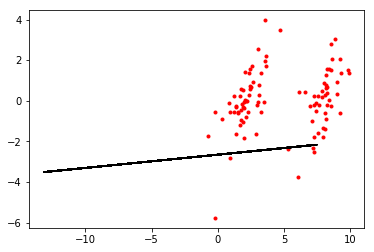

In [125]:
plt.plot(dataArray[:, 0], dataArray[:, 1], 'r.')
plt.plot(yArray[:, 0], yArray[:, 1], 'k-')
plt.show()
